# Hypothesis
Say we have two different looking pages on a site, and we want to determine which one helps us get more people convert from visit to registration per se.
Before we create the dataframe for analysis, we need to define our null and alternative hypothesis first. Our metric here will be conversion rate, so we can define our Null hypothesis as __the new page will not change the conversion rate__, and that is P(convert)ₙ = P(convert)ₒ, which equals to the convert_overall variable, which we will calculate later. So, the Alternative hypothesis would be the new page brings us a different conversion rate than the old one does, in other words, they don’t come from the same population.

### Confidence Level
The appropriate confidence level vary case by case, but here, we will use a standard 95% confidence level, which means we want to be 95% sure that the control and treatment come from the same population, and that their conversion rates are not different. As such, our p-value will be 0.05.

In [1]:
import pandas as pd
from datetime import datetime, timedelta
import random
import numpy as np
import plotly.express as px

#### First of all we create the df

In [2]:
# create a list of variants
variant_list = ['old_page', 'new_page']

# assign user_id's, page variants and binary feature representing whether user has registered or not
data = {
    'user_id': [f'user_{x}' for x in range(1000)],
    'variant': [random.choice(variant_list) for _ in range(1000)],
    'converted': [random.randint(0, 1) for _ in range(1000)]
}

# create a df with our data
df = pd.DataFrame(data)

# add a group column
df['group'] = [None for _ in range(1000)]

# assign values to the group column according to what page the users saw
df.loc[df['variant'] == 'old_page', 'group'] = 'control'
df.loc[df['variant'] == 'new_page', 'group'] = 'treatment'

In [3]:
# Then we'll calculate the overall conversion of users as we mentioned earlier
convert_overall = df.converted.mean()
convert_overall

0.466

Now, let’s see how many users were assigned to control (old page) and treatment (new page) group, what their conversion rates are, and what the difference is.

In [4]:
size_old = sum(df.group == 'control')
control_convert = df.query('group == "control"')['converted'].mean()
size_new = sum(df.group == 'treatment')
treatment_convert = df.query('group == "treatment"')['converted'].mean()
print('There are {} users in the control group, and the conversion rate is {:.4f}.'.format(size_old, control_convert))
print('There are {} users in the treatment group, and the conversion rate is {:.4f}.'.format(size_new, treatment_convert))
print('The observed difference in conversion rate between control and treatment is {:.4f}.'.format(treatment_convert - control_convert))

There are 498 users in the control group, and the conversion rate is 0.4799.
There are 502 users in the treatment group, and the conversion rate is 0.4522.
The observed difference in conversion rate between control and treatment is -0.0277.


# Bootstrapping

The idea of bootstrapping is using random sampling with replacement to perform inference about a population. There are 3 major steps to perform it:
* Step 1: Make Bootstrapped datasets under the Null
* Step 2: Calculate the difference
* Step 3: Repeat step 1 & 2 to form a distribution of the mean difference.

## Step 1: Make Bootstrapped datasets under the Null

We will simulate nₙ transactions with conversion rate of P(convert)ₙ and simulate nₒ transactions with conversion rate of P(convert)ₒ under the Null. Remember, in a perfect world where we have control over everything, if our Null Hypothesis is true, then we can expect the difference in conversion rate between old page (control) and new page (treatment) to be 0. So P(convert)ₙ = P(convert)ₒ = *convert_overall*.



In [5]:
new_page_converted = np.random.binomial(1, convert_overall, size_new)
old_page_converted = np.random.binomial(1, convert_overall, size_old)

## Step 2: Calculate the difference

In this example, we will calculate the difference in mean of conversion rate between control and treatment groups.

In [6]:
new_page_converted.mean() - old_page_converted.mean()

-0.03566457063313011

## Step 3: Repeat step 1 & 2 to form a distribution of the mean difference.

In [7]:
p_diffs = []
for _ in range(10000):
    sample_new = np.random.binomial(1, convert_overall, size_new)
    sample_old = np.random.binomial(1, convert_overall, size_old)
    sample_new_mean = sample_new.mean()
    sample_old_mean = sample_old.mean()
    p_diffs.append(sample_new_mean - sample_old_mean)

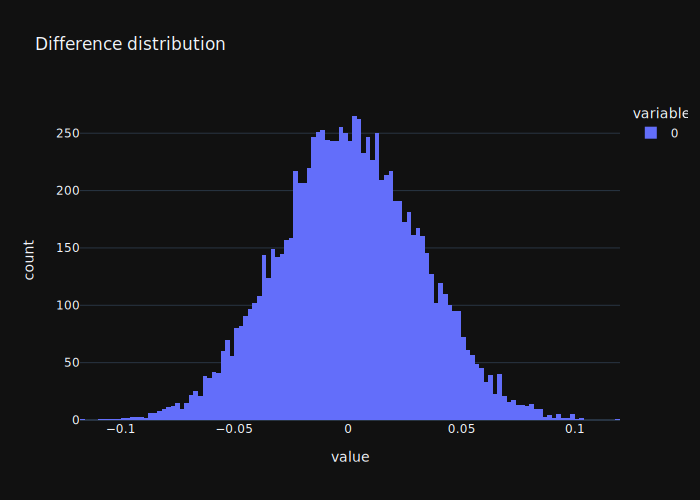

In [8]:
# lets plot the difference distribution
fig = px.histogram(p_diffs, title='Difference distribution')
fig.show(renderer='svg')

# Calculate p-value
Remember, the observed difference between the conversion rate from old page and new page is *convert_overall*, and since the distribution here shows us what would happen if our Null hypothesis is true, we can use it to calculate the p-value for observing a difference of *convert_overall* or something more extreme, where more extreme means further from the null hypothesis than the observed difference, which in this case, means further than *convert_overall* or *-convert_overall* from 0.

So, the p-value for the observed diff, *convert_overall*, is the probability of observing a boostrapped diff >= *convert_overall* plus the probability of observing a bootstrapped diff <= *-convert_overall*.

In [9]:
obs_diff = treatment_convert - control_convert

In [10]:
# If the value is more than .5 then we failed to reject our null hypothesis, otherwise we succeed in that
# In other words, the chance of the new page being more helpful for conversion is higher or lower than 50%
np.logical_or(np.array(p_diffs) >= obs_diff, np.array(p_diffs) <= -obs_diff).mean()

1.0

# We also can wrap this in two little functions and play with them for a bit. Mind that np.random produces normally distributed values, so we will rarely see a p-value other than 1.0

In [11]:
# define the function for df creation
def create_ab_df(size: int):
    # create a list of variants
    variant_list = ['old_page', 'new_page']

    # assign data to a dictionary skipping the variables as this doesn't take much space
    data = {
        'user_id': [f'user_{x}' for x in range(size)],
        'variant': [random.choice(variant_list) for _ in range(size)],
        'converted': [random.randint(0, 1) for _ in range(size)]
    }

    # create a df with our data
    df = pd.DataFrame(data)

    # add a group column
    df['group'] = [None for _ in range(size)]

    # assign values to the group column according to what page the users saw
    df.loc[df['variant'] == 'old_page', 'group'] = 'control'
    df.loc[df['variant'] == 'new_page', 'group'] = 'treatment'

    return df

In [12]:
# a function for bootstrapping
def bootstrap(data: pd.DataFrame):
    convert_overall = data.converted.mean()
    print('Overall conversion:', convert_overall)
    size_old = sum(data.group == 'control')
    control_convert = data.query('group == "control"')['converted'].mean()
    size_new = sum(data.group == 'treatment')
    treatment_convert = data.query('group == "treatment"')['converted'].mean()
    print('There are {} users in the control group, and the conversion rate is {:.4f}.'.format(size_old, control_convert))
    print('There are {} users in the treatment group, and the conversion rate is {:.4f}.'.format(size_new, treatment_convert))
    print(
        'The observed difference in conversion rate between control and treatment is {:.4f}.'.format(
            treatment_convert - control_convert
        )
    )

    p_diffs = []
    for _ in range(10000):
        sample_new = np.random.binomial(1, convert_overall, size_new)
        sample_old = np.random.binomial(1, convert_overall, size_old)
        sample_new_mean = sample_new.mean()
        sample_old_mean = sample_old.mean()
        p_diffs.append(sample_new_mean - sample_old_mean)

    fig = px.histogram(
        p_diffs,
        title='Difference distribution',
        opacity=.5
    )
    fig.show(renderer='svg')

    obs_diff = treatment_convert - control_convert
    p_value = np.logical_or(
        np.array(p_diffs) >= obs_diff,
        np.array(p_diffs) <= -obs_diff
    ).mean()
    print('P-Value is:', p_value)

    if p_value >= .05:
        print('Null hypothesis confirmed')
    else:
        print('Null hypothesis rejected')

Overall conversion: 0.4979
There are 4934 users in the control group, and the conversion rate is 0.5004.
There are 5066 users in the treatment group, and the conversion rate is 0.4955.
The observed difference in conversion rate between control and treatment is -0.0049.


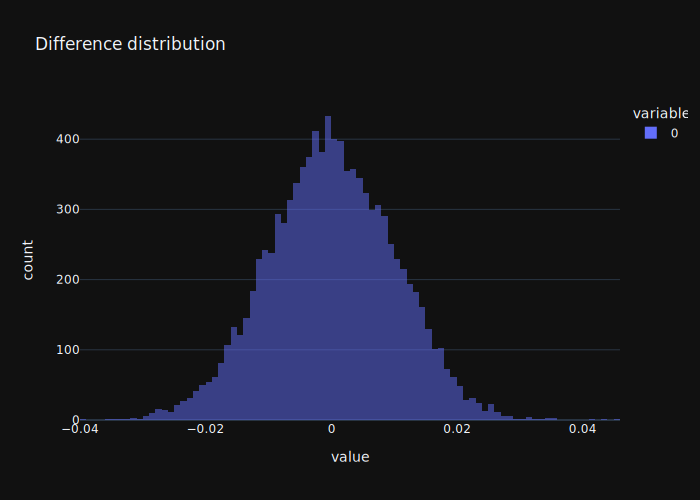

P-Value is: 1.0
Null hypothesis confirmed


In [13]:
# putting it all together
bootstrap(create_ab_df(10000))

# We can slightly alter the starting dataframe to look at another point of view on the data

In [14]:
# First define the function for creating a random data df
def create_num_users_df(days: int):
    # create a list of dates
    date_list = [datetime.today() - timedelta(days=x) for x in range(days)]
    # create a randomly distributed list of variants
    variant_list = [random.choice(['A', 'B']) for _ in range(days)]
    # create a randomly distributed list of number of visits
    visit_list = [random.randint(100, 2500) for _ in range(days)]
    # create a randomly distributed list of number of registrations
    registration_list = [random.randint(50, x) for x in visit_list]
    # pack it in a dictionary
    data = {
        'date': date_list,
        'variant': variant_list,
        'visit': visit_list,
        'registration': registration_list
    }
    # create a df from our dictionary
    df = pd.DataFrame(data)
    # return the dictionary
    return df

In [40]:
# Then the function for bootstrapping
def bootstrap_num_users(frame: pd.DataFrame):
    # calculate the conversion rate from visit into registration
    frame['conversion_rate'] = frame['registration'] / frame['visit']

    # calculate overall conversion rate
    convert_overall = frame.conversion_rate.mean()

    # same as before calculate the number of days with A and B groups and their conversion rates
    size_old = sum(frame['variant'] == 'A')
    control_convert = frame.query('variant == "A"')['conversion_rate'].mean()
    size_new = sum(frame['variant'] == 'B')
    treatment_convert = frame.query('variant == "B"')['conversion_rate'].mean()

    # print those numbers out
    print('Overall conversion:', convert_overall)
    print('There are {} days in the control group, and the conversion rate is {:.4f}.'.format(size_old, control_convert))
    print('There are {} days in the treatment group, and the conversion rate is {:.4f}.'.format(size_new, treatment_convert))
    print(
        'The observed difference in conversion rate between control and treatment is {:.4f}.'.format(
            treatment_convert - control_convert
        )
    )

    # define empty lists for overrall, A and B conversion means
    conversion_rate_means = []
    conversion_rate_means_A = []
    conversion_rate_means_B = []

    # take 1000 samples from the data
    for _ in range(10000):
        # take a random fraction of our data
        sample = frame.sample(frac=1, replace=True)

        # calculate it's mean, and means of A and B variants in that fraction
        mean = sample['conversion_rate'].mean()
        mean_A = sample[sample.variant == 'A']['conversion_rate'].mean()
        mean_B = sample[sample.variant == 'B']['conversion_rate'].mean()

        # append calculated means to the placeholders we created earlier
        conversion_rate_means_A.append(mean_A)
        conversion_rate_means_B.append(mean_B)
        conversion_rate_means.append(mean_B - mean_A)

    # calculate the 95% confidence interval
    confidence_interval = np.percentile(conversion_rate_means, [2.5, 95.5])

    # show the distribution of overall means
    fig_1 = px.histogram(conversion_rate_means, title='Distribution histogram')
    fig_1.show(renderer='svg')

    # to show the distributions of A and B variants separately we need to concatenate A and B means in one df to then show them overlaying each other
    # first create a temporary df for A variant and fill the second column with "A"s
    temp_df_1 = pd.DataFrame(
        data={
            'mean': conversion_rate_means_A,
            'group': ['A' for _ in range(len(conversion_rate_means_A))]
        }
    )
    # do the same for B variant
    temp_df_2 = pd.DataFrame(
        data={
            'mean': conversion_rate_means_B,
            'group': ['B' for _ in range(len(conversion_rate_means_B))]
        }
    )
    # concat them in one df
    concatenated = pd.concat([temp_df_1, temp_df_2])

    # get rid of temporary dfs
    del temp_df_1, temp_df_2

    # show them overlaying
    fig_2 = px.histogram(
        concatenated,
        x='mean',
        color='group',
        barmode='overlay',
        title='Overlaying A and B variants distribution'
    )
    fig_2.show(renderer='svg')

    # calculate the p-value
    p_value = np.mean(conversion_rate_means)

    # print all remaining information
    print('P-value is:', p_value)
    print('The 95% confidence interval is:', confidence_interval)

    # print our final statement
    if p_value >= .05:
        print('Null hypothesis confirmed')
    else:
        print('Null hypothesis rejected')

Overall conversion: 0.5856184772768924
There are 16 days in the control group, and the conversion rate is 0.6243.
There are 14 days in the treatment group, and the conversion rate is 0.5414.
The observed difference in conversion rate between control and treatment is -0.0829.


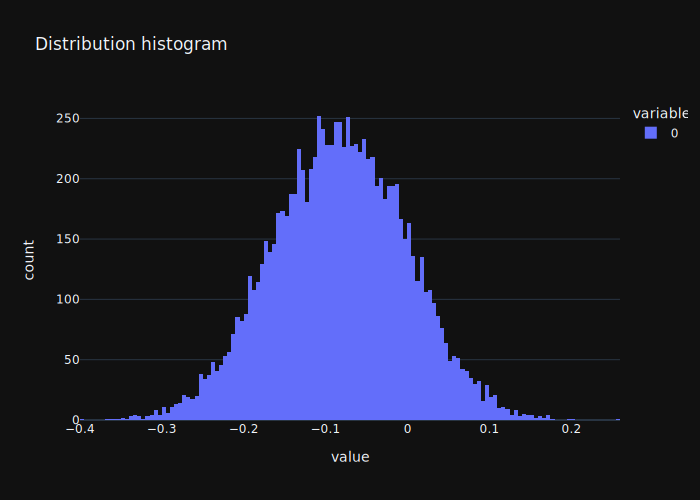

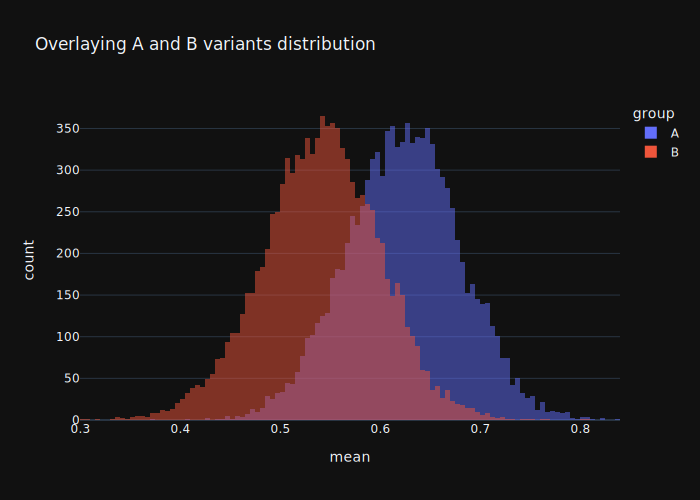

P-value is:: -0.08283626337194976
The 95% confidence interval is: [-0.24364844  0.05437884]
Null hypothesis rejected


In [41]:
# let's see what we ended up with
bootstrap_num_users(create_num_users_df(30))

# But we would rarely collect data in such a way.
#### What we would usually do is for each day measure visits and registrations for both groups.
So our dataframe would contain each date twice: one for A variant and one for B variant

In [34]:
# Let's create such a dataframe
def create_num_users_df_equal_days(days: int):
    # create a visit list for A and B groups
    visit_A = [random.randint(100, 2500) for _ in range(days)]
    visit_B = [random.randint(100, 2500) for _ in range(days)]

    # create separate dicts for A and B dfs
    data_A = {
        'date': [(datetime.today() - timedelta(days=x)).date() for x in range(days)],
        'variant': ['A' for _ in range(days)],
        'visit': visit_A,
        'registration': [random.randint(50, x) for x in visit_A]
    }
    data_B = {
        'date': [(datetime.today() - timedelta(days=x)).date() for x in range(days)],
        'variant': ['B' for _ in range(days)],
        'visit': visit_B,
        'registration': [random.randint(50, x) for x in visit_B]
    }

    # concatenate two dfs on the fly
    concat = pd.concat([pd.DataFrame(data_A), pd.DataFrame(data_B)])
    return concat

In [42]:
# let's make sure we did the right thing
df = create_num_users_df_equal_days(30)

In [43]:
# seems like we did
df.groupby(['date', 'variant']).mean()

visit  registration
date       variant                      
2022-12-31 A         318.0         312.0
           B        1918.0        1772.0
2023-01-01 A        1462.0        1364.0
           B        1600.0        1347.0
2023-01-02 A        1558.0         521.0
           B        1035.0         527.0
2023-01-03 A         617.0         599.0
           B         447.0         285.0
2023-01-04 A        1871.0         969.0
           B        1042.0         316.0
2023-01-05 A        1778.0         742.0
           B        2038.0        1651.0
2023-01-06 A        2139.0         142.0
           B        1221.0         942.0
2023-01-07 A        1042.0        1019.0
           B        1392.0         861.0
2023-01-08 A         617.0         146.0
           B        2219.0        2022.0
2023-01-09 A         718.0         112.0
           B        2377.0          67.0
2023-01-10 A         415.0         289.0
           B        2332.0        1212.0
2023-01-11 A         166.0          65.0
           B         602.0         235.0
2023-01-12 A        1499.0         889.0
           B        2299.0        2116.0
2023-01-13 A        1248.0         375.0
           B         202.0         136.0
2023-01-14 A         731.0         320.0
           B        1290.0         541.0
2023-01-15 A         807.0         759.0
           B        1280.0         836.0
2023-01-16 A         105.0          97.0
           B         424.0         422.0
2023-01-17 A        1132.0         102.0
           B        2257.0        1748.0
2023-01-18 A         794.0         490.0
           B         691.0         201.0
2023-01-19 A         718.0         589.0
           B        2199.0        2191.0
2023-01-20 A        2224.0        1753.0
           B        1385.0        1327.0
2023-01-21 A         317.0          56.0
           B         402.0         309.0
2023-01-22 A         264.0         145.0
           B         319.0         228.0
2023-01-23 A        1148.0         952.0
           B         609.0         261.0
2023-01-24 A        1289.0         813.0
           B         407.0         267.0
2023-01-25 A        2438.0        1788.0
           B        1794.0        1791.0
2023-01-26 A        2333.0        1075.0
           B         542.0         357.0
2023-01-27 A        2467.0        2099.0
           B         164.0         153.0
2023-01-28 A         661.0         556.0
           B         736.0         403.0
2023-01-29 A         847.0         709.0
           B         620.0         168.0

Overall conversion: 0.6337186529580167
There are 30 days in the control group, and the conversion rate is 0.6033.
There are 30 days in the treatment group, and the conversion rate is 0.6641.
The observed difference in conversion rate between control and treatment is 0.0608.


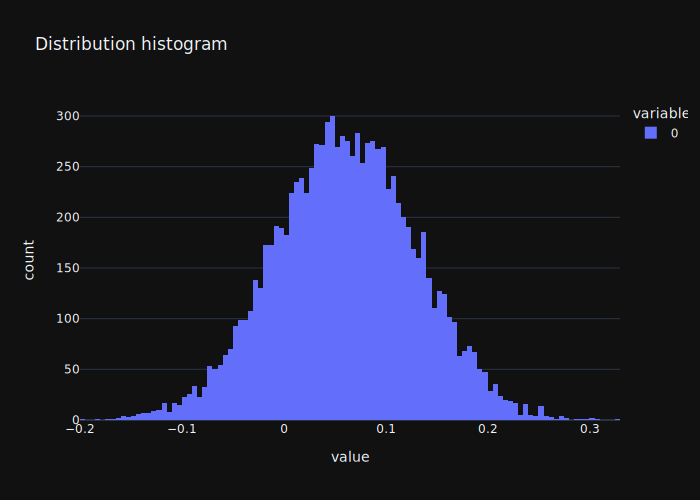

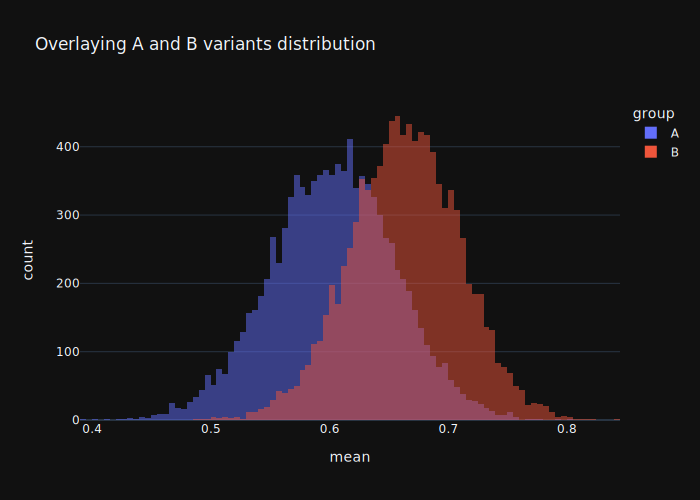

P-value is:: 0.060730498682390256
The 95% confidence interval is: [-0.07519375  0.17989361]
Null hypothesis confirmed


In [44]:
# Now let's bootstrap it
bootstrap_num_users(df)

Overall conversion: 0.5071519172573509
There are 30 days in the control group, and the conversion rate is 0.4470.
There are 30 days in the treatment group, and the conversion rate is 0.5673.
The observed difference in conversion rate between control and treatment is 0.1202.


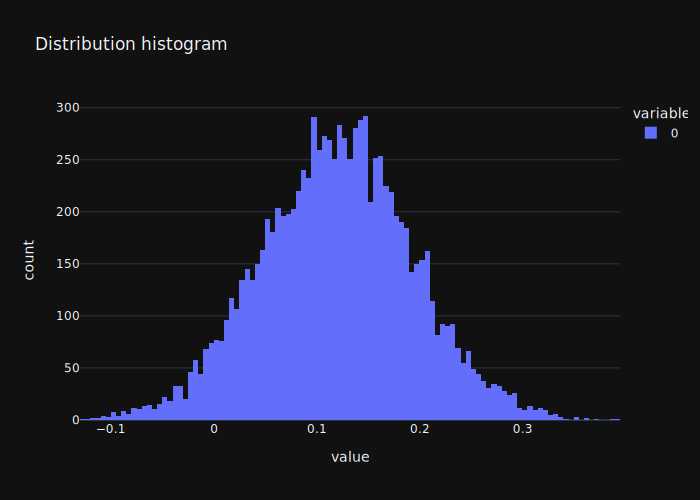

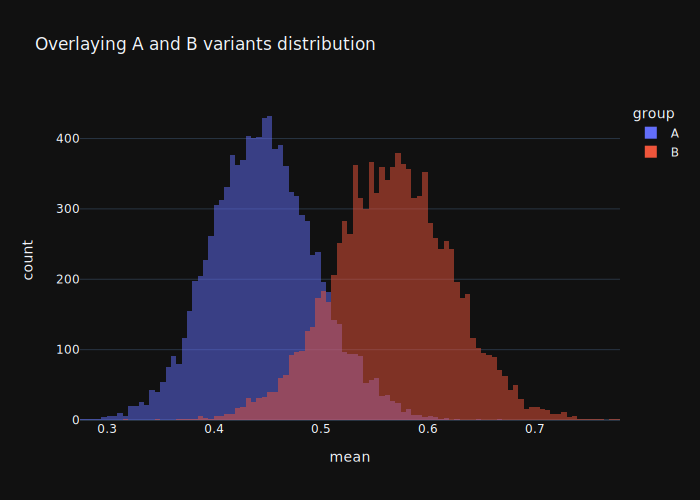

P-value is:: 0.11994775332944237
The 95% confidence interval is: [-0.02375174  0.24605535]
Null hypothesis confirmed


In [45]:
# and play with it a little more
bootstrap_num_users(create_num_users_df_equal_days(30))